In [9]:
import numpy as np

def rbf_kernel(x, xp, ell, sigma_f):
    """
    RBF kernel k(x, x') = sigma_f^2 * exp(-(x-x')^2 / (2*ell^2))

    x  : shape (N,)
    xp : shape (M,)
    returns: shape (N, M)
    """
    x = x[:, None]
    xp = xp[None, :]
    sqdist = (x - xp)**2
    return sigma_f**2 * np.exp(-0.5 * sqdist / ell**2)


In [10]:
import numpy as np

def gp_log_marginal_likelihood(x, y, ell, sigma_f, sigma_y):
    """
    Computes log p(y | X, theta, sigma_y^2) for 1D GP with RBF kernel.
    
    x : shape (n,)
    y : shape (n,)
    """
    n = len(x)
    
    # Compute kernel matrix
    K = rbf_kernel(x, x, ell, sigma_f)
    
    # Add noise variance
    Ky = K + sigma_y**2 * np.eye(n)
    
    # Cholesky decomposition
    try:
        L = np.linalg.cholesky(Ky)
    except np.linalg.LinAlgError:
        return -np.inf   # invalid hyperparameters
    
    # Solve for alpha = (K + σ²I)^(-1) y using Cholesky
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
    
    # log determinant via Cholesky
    logdet = 2 * np.sum(np.log(np.diag(L)))
    
    # log marginal likelihood
    lml = -0.5 * y.T @ alpha - 0.5 * logdet - 0.5 * n * np.log(2*np.pi)
    return lml


In [ ]:
def fit_gp_hyperparams(x, y, fix_sigma_y=None):
    """
    Returns best (ell, sigma_f, sigma_y, best_lml)
    If fix_sigma_y is not None, sigma_y is fixed.
    """
    ells = np.logspace(-2, 1, 20)       
    sigmas_f = np.logspace(-2, 1, 20)   
    
    if fix_sigma_y is None:
        sigmas_y = np.logspace(-3, -1, 10)   
    else:
        sigmas_y = [fix_sigma_y]
    
    best = (-np.inf, None, None, None)
    
    for ell in ells:
        for sf in sigmas_f:
            for sy in sigmas_y:
                lml = gp_log_marginal_likelihood(x, y, ell, sf, sy)
                if lml > best[0]:
                    best = (lml, ell, sf, sy)
    
    best_lml, ell, sf, sy = best
    return ell, sf, sy, best_lml


In [ ]:
import numpy as np

data = np.loadtxt("data_part_B.csv", delimiter=",")

# columns
x_noisy = data[:,0]     # xi
y = data[:,1]          # yi
Delta = data[:,2]      # Δi 

x_true = x_noisy - Delta


In [13]:
# Model (a): noisy xi, sigma_y free
ell_a, sf_a, sy_a, lml_a = fit_gp_hyperparams(x_noisy, y)

# Model (b): noisy xi, sigma_y fixed
ell_b, sf_b, sy_b, lml_b = fit_gp_hyperparams(x_noisy, y, fix_sigma_y=0.0025)

# Model (c): true x, sigma_y fixed
ell_c, sf_c, sy_c, lml_c = fit_gp_hyperparams(x_true, y, fix_sigma_y=0.0025)


In [14]:
def gp_posterior(x_train, y_train, x_test, ell, sigma_f, sigma_y):
    # kernel matrices
    K = rbf_kernel(x_train, x_train, ell, sigma_f)
    K_s = rbf_kernel(x_train, x_test, ell, sigma_f)
    K_ss = rbf_kernel(x_test, x_test, ell, sigma_f)

    n = len(x_train)
    Ky = K + sigma_y**2 * np.eye(n)

    # Cholesky
    L = np.linalg.cholesky(Ky)

    # compute alpha = (K+σ²I)^(-1) y
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y_train))

    # posterior mean
    mu = K_s.T @ alpha

    # posterior variance
    v = np.linalg.solve(L, K_s)
    var = np.diag(K_ss) - np.sum(v**2, axis=0)

    return mu, var


In [15]:
x_test = np.linspace(-1, 1, 200)

# (a)
mu_a, var_a = gp_posterior(x_noisy, y, x_test, ell_a, sf_a, sy_a)

# (b)
mu_b, var_b = gp_posterior(x_noisy, y, x_test, ell_b, sf_b, sy_b)

# (c)
mu_c, var_c = gp_posterior(x_true, y, x_test, ell_c, sf_c, sy_c)

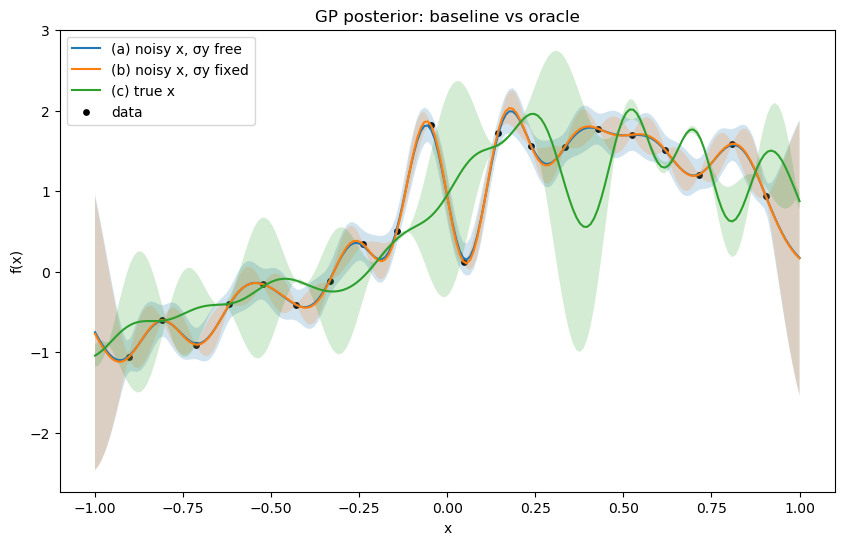

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))

# data
plt.scatter(x_noisy, y, c="k", s=15, label="data")

# model (a)
plt.plot(x_test, mu_a, label="(a) noisy x, σy free")
plt.fill_between(x_test, 
                 mu_a - 1.96*np.sqrt(var_a),
                 mu_a + 1.96*np.sqrt(var_a),
                 alpha=0.2)

# model (b)
plt.plot(x_test, mu_b, label="(b) noisy x, σy fixed")
plt.fill_between(x_test, 
                 mu_b - 1.96*np.sqrt(var_b),
                 mu_b + 1.96*np.sqrt(var_b),
                 alpha=0.2)

# model (c)
plt.plot(x_test, mu_c, label="(c) true x")
plt.fill_between(x_test, 
                 mu_c - 1.96*np.sqrt(var_c),
                 mu_c + 1.96*np.sqrt(var_c),
                 alpha=0.2)

plt.legend()
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("GP posterior: baseline vs oracle")
plt.show()


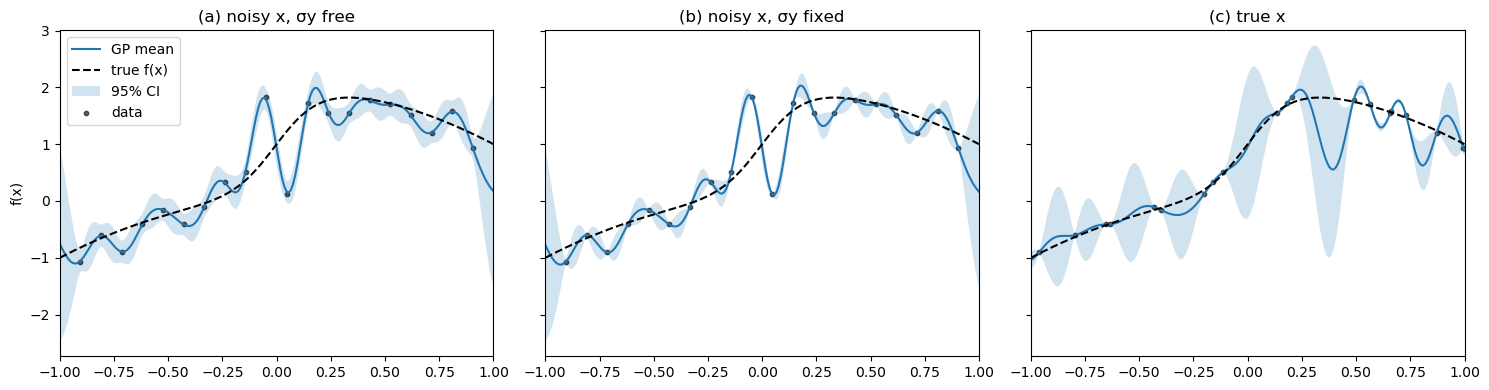

In [17]:
def f_true(x):
    return -x**2 + 2/(1 + np.exp(-10*x))

x_test = np.linspace(-1,1,200)

y_true = f_true(x_test)

fig, axs = plt.subplots(1, 3, figsize=(15,4), sharey=True)

models = [
    ("(a) noisy x, σy free", x_noisy, ell_a, sf_a, sy_a),
    ("(b) noisy x, σy fixed", x_noisy, ell_b, sf_b, sy_b),
    ("(c) true x", x_true, ell_c, sf_c, sy_c),
]

for ax, (title, x_train, ell, sf, sy) in zip(axs, models):
    mu, var = gp_posterior(x_train, y, x_test, ell, sf, sy)
    std = np.sqrt(var)

    # GP mean and CI
    ax.plot(x_test, mu, label="GP mean")
    ax.fill_between(x_test, mu-1.96*std, mu+1.96*std, alpha=0.2, label="95% CI")

    # True function
    ax.plot(x_test, y_true, "k--", label="true f(x)")

    # Scatter
    ax.scatter(x_train, y, s=10, c="k", alpha=0.6, label="data")

    ax.set_title(title)
    ax.set_xlim([-1,1])

axs[0].set_ylabel("f(x)")
axs[0].legend(loc="best")
plt.tight_layout()
plt.show()


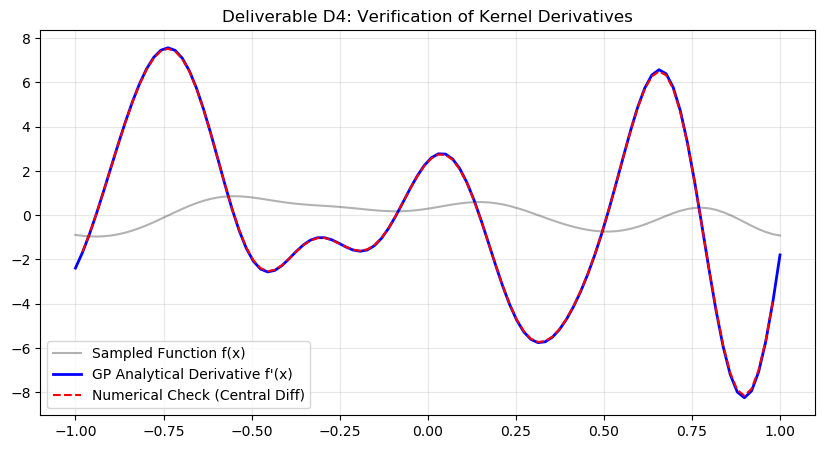

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

def rbf_kernel_derivs(X1, X2, sigma_f=1.0, ell=0.2):
    X1 = X1.reshape(-1, 1)
    X2 = X2.reshape(-1, 1)
    
    dist_sq = cdist(X1, X2, 'sqeuclidean') # (x - x')^2
    diff = X1 - X2.T                       # (x - x')
    ell2 = ell**2
    
    K = (sigma_f**2) * np.exp(-0.5 * dist_sq / ell2)
    
    # K1_ij = d/dx_i k(x_i, x_j) = - (x_i - x_j)/l^2 * k
    K1 = -(diff / ell2) * K
    
    # K2_ij = d^2/dxdx' k = 1/l^2 * (1 - (x-x')^2/l^2) * k
    K2 = (1.0 / ell2) * (1.0 - dist_sq / ell2) * K
    
    return K, K1, K2


def generate_d4_plot():
    np.random.seed(42) 
    X_grid = np.linspace(-1, 1, 100)
    n = len(X_grid)
    
    K, K1, K2 = rbf_kernel_derivs(X_grid, X_grid)
    
    top = np.hstack([K, K1.T])
    bottom = np.hstack([K1, K2])
    Sigma_joint = np.vstack([top, bottom])
    
    Sigma_joint += 1e-8 * np.eye(2 * n)
    
    sample = np.random.multivariate_normal(np.zeros(2 * n), Sigma_joint)
    f_sample = sample[:n]        
    df_sample_gp = sample[n:]    
    
    df_numerical = np.zeros(n)
    h = X_grid[1] - X_grid[0]
    for i in range(1, n-1):
        df_numerical[i] = (f_sample[i+1] - f_sample[i-1]) / (2 * h)
        
    plt.figure(figsize=(10, 5))
    plt.plot(X_grid, f_sample, 'k-', alpha=0.3, label='Sampled Function f(x)')
    plt.plot(X_grid, df_sample_gp, 'b-', lw=2, label="GP Analytical Derivative f'(x)")
    plt.plot(X_grid[1:-1], df_numerical[1:-1], 'r--', label="Numerical Check (Central Diff)")
    
    plt.title("Deliverable D4: Verification of Kernel Derivatives")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

generate_d4_plot()

In [19]:
def marginalize_over_Delta(X, K, K1, K2, sigma_y2, sigma_x2, M=100):
    n = len(X)
    means = []
    covs = []

    for _ in range(M):
        Delta = np.random.normal(0, np.sqrt(sigma_x2), size=n)
        D = np.diag(Delta)

        Sigma_y = K - K1.T @ D - D @ K1 + D @ K2 @ D + sigma_y2*np.eye(n)

        means.append(np.zeros(n))
        covs.append(Sigma_y)

    mean = np.mean(means, axis=0)
    cov = np.mean([C + np.outer(m,m) for C,m in zip(covs,means)], axis=0) - np.outer(mean,mean)
    return mean, cov


In [31]:
def sample_posterior_Delta(x, y, ell, sigma_f, sigma_y2, sigma_x2, M=5000):
    n = len(x)
    K, K1, K2 = rbf_kernel_derivs(x, x, sigma_f, ell)

    Deltas = np.random.normal(0, np.sqrt(sigma_x2), size=(M, n))
    logw = np.zeros(M)

    for m in range(M):
        Delta = Deltas[m]
        D = np.diag(Delta)
        Sigma_y = K - K1.T @ D - D @ K1 + D @ K2 @ D + sigma_y2*np.eye(n)

        try:
            L = np.linalg.cholesky(Sigma_y + 1e-8*np.eye(n))
        except:
            logw[m] = -np.inf
            continue

        alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
        logdet = 2*np.sum(np.log(np.diag(L)))

        loglik = -0.5*y@alpha - 0.5*logdet
        logprior = -0.5*np.sum(Delta**2)/sigma_x2

        logw[m] = loglik + logprior

    w = np.exp(logw - np.max(logw))
    w = w / np.sum(w)

    idx = np.random.choice(M, size=1000, p=w)
    return Deltas[idx]


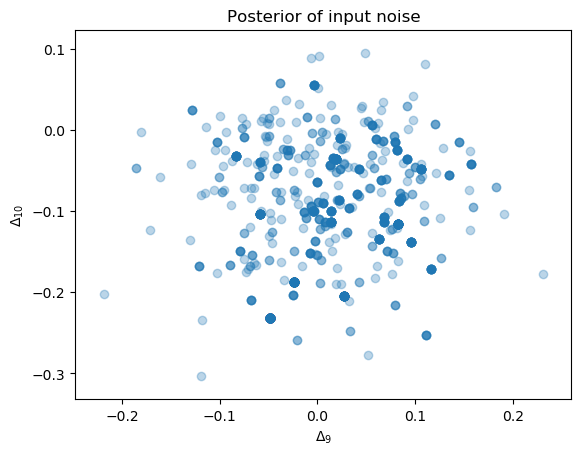

In [32]:
samples = sample_posterior_Delta(x_noisy, y, ell, sigma_f, sigma_y2, sigma_x2)

plt.scatter(samples[:,8], samples[:,9], alpha=0.3)
plt.xlabel(r"$\Delta_9$")
plt.ylabel(r"$\Delta_{10}$")
plt.title("Posterior of input noise")
plt.show()


In [56]:
Delta = data[:,2]
D = np.diag(Delta)

def Sigma_y_given_D(x, ell, sigma_f, sigma_y2, Delta):
    K, K1, K2 = rbf_kernel_derivs(x, x, sigma_f, ell)
    Dmat = np.diag(Delta)
    return K - K1.T@Dmat - Dmat@K1 + Dmat @ K2 @ Dmat.T + sigma_y2*np.eye(len(x))


In [58]:
def noisy_log_marginal_likelihood_given_D(x, y, ell, sigma_f, sigma_y2, Delta):
    Sigma_y = Sigma_y_given_D(x, ell, sigma_f, sigma_y2, Delta)

    try:
        L = np.linalg.cholesky(Sigma_y + 1e-8*np.eye(len(x)))
    except:
        return -np.inf

    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
    logdet = 2*np.sum(np.log(np.diag(L)))

    return -0.5*y@alpha - 0.5*logdet - 0.5*len(x)*np.log(2*np.pi)


In [59]:
ells = np.logspace(-2,1,20)
sigmas_f = np.logspace(-2,1,20)
sigmas_y = np.logspace(-3,-1,10)

best = (-np.inf, None, None, None)

for ell in ells:
    for sf in sigmas_f:
        for sy in sigmas_y:
            lml = noisy_log_marginal_likelihood_given_D(x_noisy, y, ell, sf, sy, Delta)
            if lml > best[0]:
                best = (lml, ell, sf, sy)

_, ell_opt, sigma_f_opt, sigma_y2_opt = best


In [60]:
ell = ell_opt
sigma_f = sigma_f_opt
sigma_y2 = sigma_y2_opt
sigma_x2 = 0.01 
print("ell =", ell_opt)
print("sigma_f =", sigma_f_opt)
print("sigma_y^2 =", sigma_y2_opt)


ell = 0.26366508987303583
sigma_f = 0.7847599703514611
sigma_y^2 = 0.004641588833612777


In [64]:
def noisy_gp_posterior_given_D(x_train, y, x_test, ell, sigma_f, sigma_y2, Delta):
    K, K1, K2 = rbf_kernel_derivs(x_train, x_train, sigma_f, ell)
    Dmat = np.diag(Delta)

    Sigma_y = K - K1.T@Dmat - Dmat@K1 + Dmat @ K2 @ Dmat.T + sigma_y2*np.eye(len(x_train))
    Sigma_y += 1e-6 * np.eye(len(x_train))


    L = np.linalg.cholesky(Sigma_y + 1e-8*np.eye(len(x_train)))
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))

    # prediction kernel (Delta=0 for test point)
    k_star = rbf_kernel(x_test, x_train, ell, sigma_f)
    dk_star = -(x_test[:,None] - x_train[None,:])/(ell**2) * k_star
    k_eff = k_star - dk_star @ Dmat

    mu = k_eff @ alpha

    v = np.linalg.solve(L, k_eff.T)
    var = sigma_f**2 - np.sum(v**2, axis=0)

    return mu, var


C:\Windows\Temp\ipykernel_13528\3239467238.py:12: RuntimeWarning: invalid value encountered in sqrt
  mu - 1.96*np.sqrt(var),
C:\Windows\Temp\ipykernel_13528\3239467238.py:13: RuntimeWarning: invalid value encountered in sqrt
  mu + 1.96*np.sqrt(var),


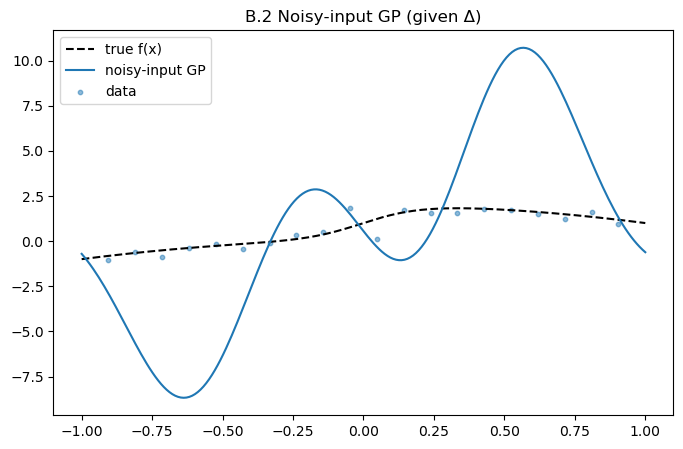

In [65]:
x_grid = np.linspace(-1,1,200)
y_true = f_true(x_grid)

mu, var = noisy_gp_posterior_given_D(x_noisy, y, x_grid,
                                    ell_opt, sigma_f_opt, sigma_y2_opt, Delta)

plt.figure(figsize=(8,5))
plt.scatter(x_noisy, y, s=10, alpha=0.5, label="data")
plt.plot(x_grid, y_true, "k--", label="true f(x)")
plt.plot(x_grid, mu, label="noisy-input GP")
plt.fill_between(x_grid,
                 mu - 1.96*np.sqrt(var),
                 mu + 1.96*np.sqrt(var),
                 alpha=0.3)
plt.legend()
plt.title("B.2 Noisy-input GP (given Δ)")
plt.show()



In [ ]:
def noisy_gp_predictive(x_star, X, y, ell, sigma_f, sigma_y2, sigma_x2, M=100):
    n = len(X)

    # kernels between training points
    K, K1, K2 = rbf_kernel_derivs(X, X, sigma_f, ell)

    mu_samples = []
    var_samples = []

    for _ in range(M):
        # sample Delta
        Delta = np.random.normal(0, np.sqrt(sigma_x2), size=n)
        D = np.diag(Delta)

        # Sigma_y from D4
        Sigma_y = K - K1.T @ D - D @ K1 + D @ K2 @ D + sigma_y2*np.eye(n)

        # Cholesky
        L = np.linalg.cholesky(Sigma_y + 1e-8*np.eye(n))
        alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))

        # kernel between x* and training
        k_star = rbf_kernel(x_star*np.ones(1), X, ell, sigma_f).flatten()
        dk_star = -(x_star - X) / (ell**2) * k_star

        # mean
        mu = (k_star - dk_star @ D) @ alpha

        # variance
        v = np.linalg.solve(L, (k_star - dk_star @ D))
        var = sigma_f**2 - v @ v

        mu_samples.append(mu)
        var_samples.append(var)

    # Monte-Carlo marginalization
    mu_hat = np.mean(mu_samples)
    var_hat = np.mean([v + m**2 for v,m in zip(var_samples,mu_samples)]) - mu_hat**2

    return mu_hat, var_hat


In [ ]:
def noisy_log_marginal_likelihood(x, y, ell, sigma_f, sigma_y2, sigma_x2):
    n = len(x)
    K, K1, K2 = rbf_kernel_derivs(x, x, sigma_f, ell)

    # expected Sigma_y over Delta (Girard approximation)
    D2 = sigma_x2 * np.eye(n)
    Sigma_y = K + D2 @ K2 @ D2 + sigma_y2 * np.eye(n)

    try:
        L = np.linalg.cholesky(Sigma_y + 1e-8*np.eye(n))
    except np.linalg.LinAlgError:
        return -np.inf

    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
    logdet = 2*np.sum(np.log(np.diag(L)))

    return -0.5*y@alpha - 0.5*logdet - 0.5*n*np.log(2*np.pi)


In [ ]:
ells = np.logspace(-2,1,20)
sigmas_f = np.logspace(-2,1,20)
sigmas_y = np.logspace(-3,-1,10)

best = (-np.inf, None, None, None)

for ell in ells:
    for sf in sigmas_f:
        for sy in sigmas_y:
            lml = noisy_log_marginal_likelihood(x_noisy, y, ell, sf, sy, sigma_x2=0.01)
            if lml > best[0]:
                best = (lml, ell, sf, sy)

_, ell_opt, sigma_f_opt, sigma_y2_opt = best


In [ ]:
ell = ell_opt
sigma_f = sigma_f_opt
sigma_y2 = sigma_y2_opt
sigma_x2 = 0.01

In [ ]:
x_grid = np.linspace(-1,1,200)
y_true = f_true(x_grid)

mu_mc = []
var_mc = []

for x_star in x_grid:
    # compute kernel blocks involving x_star
    # this uses the same derivative GP logic as in D4
    
    mu, var = noisy_gp_predictive(x_star, x_noisy, y, ell, sigma_f, sigma_y2, sigma_x2, M=100)
    mu_mc.append(mu)
    var_mc.append(var)

mu_mc = np.array(mu_mc)
std_mc = np.sqrt(np.array(var_mc))


C:\Windows\Temp\ipykernel_13528\10328453.py:16: RuntimeWarning: invalid value encountered in sqrt
  std_mc = np.sqrt(np.array(var_mc))


In [ ]:
print("ell =", ell_opt)
print("sigma_f =", sigma_f_opt)
print("sigma_y^2 =", sigma_y2_opt)


ell = 0.7847599703514611
sigma_f = 1.1288378916846884
sigma_y^2 = 0.1


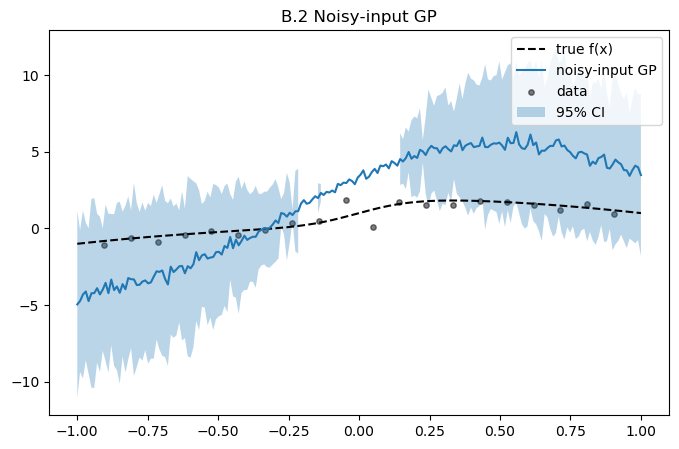

In [ ]:
plt.figure(figsize=(8,5))
plt.scatter(x_noisy, y, s=15, c="k", alpha=0.5, label="data")
plt.plot(x_grid, y_true, "k--", label="true f(x)")
plt.plot(x_grid, mu_mc, label="noisy-input GP")
plt.fill_between(x_grid,
                 mu_mc-1.96*std_mc,
                 mu_mc+1.96*std_mc,
                 alpha=0.3,
                 label="95% CI")
plt.legend()
plt.title("B.2 Noisy-input GP")
plt.show()